In [2]:
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from statistics import mean, mode, median
from matplotlib import cm, colors
from distfit import distfit
from inflection import humanize, underscore
import json
from math import sqrt



%matplotlib inline

In [3]:
def getData(metric:str, root_path:str):
    data = []
    for j in tqdm(range(len(os.listdir(root_path))), desc=metric):
        folder = os.listdir(root_path)[j]
        system_path = os.path.join(root_path, folder)
        metric_path = os.path.join(system_path, metric+'.csv')
        with open(metric_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file)
            for line in csv_reader:
                if(line[-1] != 'NaN' and line[-1] != 'nan'):
                    if(float(line[-1]) > 0 ):
                        data.append(float(line[-1]))
    data = np.sort(data)
    
    return data

metric = 'noc'
root_path = '../../Projetos/'

data = getData(metric, root_path)

noc: 100%|██████████| 44/44 [00:25<00:00,  1.74it/s]


In [4]:
np.histogram(data, bins=np.unique(data))

(array([3134, 2782, 1040,  898,  369,  378,  212,  200,  116,  136,   64,
          79,   46,   64,   31,   38,   31,   30,   22,   21,   13,   27,
          14,   30,    6,   21,   10,   11,    7,   16,    7,   11,    9,
           7,    5,    7,    7,    7,    5,    6,    3,    8,    5,    3,
           2,    2,    5,    3,    2,    3,    3,    3,    3,    3,    4,
           2,    4,    2,    1,    3,    4,    3,    1,    1,    4,    1,
           3,    1,    1,    1,    1,    2,    1,    3,    2,    2,    3,
           1,    1,    1,    2,    1,    2,    1,    1,    2,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    2],
       dtype=int64),
 array([1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 5.000e+00, 6.000e+00,
        7.000e+00, 8.000e+00, 9.000e+00, 1.000e+01, 1.100e+01, 1.200e+01,
        1.300e+01, 1.4

In [5]:
def plotHist(data, metric, path):
    plt.hist(data, bins=np.unique(data), log=True)
    plt.title("Histogram "+ metric.upper())
    plt.xlabel("Metric value")
    plt.ylabel("Frequency")
    plt.savefig(path+'/hist_'+metric+'.png')
    plt.close()

In [6]:
path = "./Graphs"
plotHist(data, metric, path)

In [9]:
import statistics


def statistic_metric(data, porcentagem):
    metric_dict = {}
    avg = np.average(data)
    median = np.median(data)
    mode = statistics.mode(data)
    std = np.std(data)
    x = porcentagem
    k = sqrt(-1/(x - 1))
    limite_inf = avg - k*std
    limite_sup = avg + k*std
    
    metric_dict = {
        'average': avg,
        'median': median,
        'mode': mode,
        'standard desviation': std,
        'chebyshev': (limite_inf, limite_sup)
    }
    
    return metric_dict

In [10]:
statistic_metric(data, 0.6)

{'average': 5.503379049890678,
 'median': 2.0,
 'mode': 1.0,
 'std': 24.175169448022874,
 'chebyshev': (-32.72092008824326, 43.72767818802461)}

In [18]:
import enum
from typing import Dict


metrics = ['noc', 'abstractMethodsQty', 'finalMethodsQty', 'privateMethodsQty', 'tryCatchQty']
root_path = "../../Projetos/"
path = "./RemoveZeroElements/Graphs/"
for metric in metrics:
    data = getData(metric, root_path)
    plotHist(data, metric, path)
    statistic: Dict = statistic_metric(data, 0.6)
    with open('./RemoveZeroElements/Statistic/'+metric+".txt", 'w') as f:
        for key in statistic:
            print(f"{key}: {statistic[key]}", file=f)
    

tryCatchQty: 100%|██████████| 44/44 [00:27<00:00,  1.63it/s]


In [51]:
def resultsFindTCC2(metric:str, root_path:str, data):
    metric_df = pd.DataFrame(data=data, columns=[metric])
    metric_df[metric] = metric_df[metric].apply(pd.to_numeric)
    metric_df_groups  = metric_df.groupby([metric])[metric].count()
    
    x = np.arange(1, 100, 1)
    y = [np.percentile(data, num) for num in x]
    mode_data = mode(data)
    avg_data = mean(data)
    median_data = median(data)
    
    
    fig_log,axs_log = plt.subplots(figsize=(25,15))

    axs_log.set_yscale('log')
    norm = colors.Normalize(vmin=min(y), vmax=max(y)+5, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Greys_r)
    aux = -1
    for i,value in enumerate(y):
        if aux == -1 or value != aux :
            axs_log.vlines(value,0, metric_df_groups.max(), linestyles='dashdot', color=mapper.to_rgba(value), label=f"Percentile {x[i]} - {value}"  )
            aux = value
    axs_log.vlines(mode_data,0, metric_df_groups.max(), linestyles='dotted', color='blue', label=f"Mode - {mode_data}"  )
    axs_log.vlines(avg_data,0, metric_df_groups.max(), linestyles='dotted', color='red', label=f"Mean - {avg_data}"  )
    axs_log.vlines(median_data,0, metric_df_groups.max(), linestyles='dotted', color='blue', label=f"Median - {median_data}"  )
    metric_df_groups.plot(ax=axs_log,title=humanize(underscore(metric)).upper()+" Log in Y")
    axs_log.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    axs_log.set_xlabel('Metric Values')
    axs_log.set_ylabel('Frequency')
    fig_log.savefig("./ResultsTCC2/Graphs/LogY/"+metric+"_logY.png")

    
    
    with open("./ResultsTCC2/Graphs/Data/"+metric+".txt", 'w') as result_file:
        print("Average: "+str(np.average(data)), file=result_file)
        print("Standard deviation: "+str(np.std(data)), file=result_file)
        print("Percentile 70: "+str(np.percentile(data, 70)), file=result_file)
        print("Percentile 90: "+str(np.percentile(data,90)), file=result_file)
    
    return data

In [54]:
data = getData('noc', root_path)

noc: 100%|██████████| 44/44 [00:20<00:00,  2.11it/s]


(array([230750, 230751, 230752, ..., 240809, 240810, 240811], dtype=int64),)

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

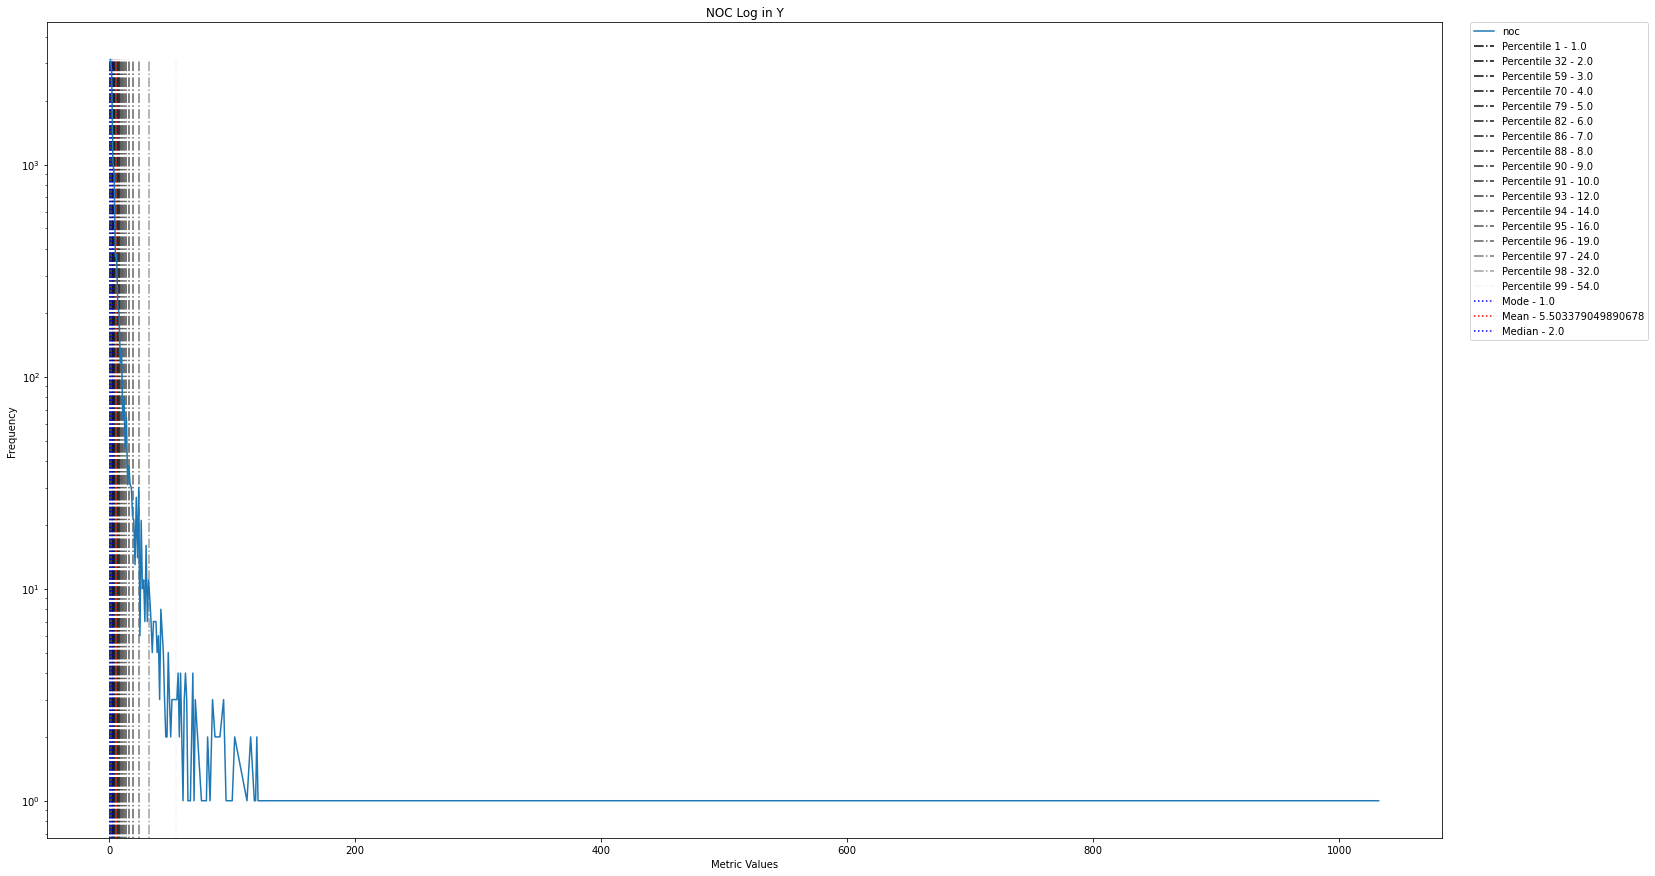

In [57]:
a = []
for value in data:
    if(value != 0):
        a.append(value)
        
resultsFindTCC2('noc', root_path, a)